In [1]:
import sys
sys.path.append("../data/saved_models/")
sys.path.append("../model_scripts/")
sys.path.append("../utils/")
import os
import json

import numpy as np
import torch

import matplotlib.pyplot as plt
import fig1_plots

import analysis_rnn as rnn
import analysis_neuro as spk
import basic_analysis as basic
import model_utils
from task import generate_batch

from scipy import stats
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from scipy.spatial import distance as dist

In [2]:
# file paths
data_folder = f"../data/saved_models/1d_2map/"
save_folder = f"../figures/fig1_plots/"

if os.path.isdir(save_folder):
    print('save folder exists')
else:
    os.mkdir(save_folder)

save folder exists


In [3]:
# get the model IDs for all saved models
model_IDs = os.listdir(data_folder)

# select example model
ex_id = 0
model_ID = model_IDs[ex_id]

In [4]:
# get sample rnn data
inputs, outputs, targets = model_utils.sample_rnn_data(data_folder, model_ID)
X, map_targ, pos_targ = model_utils.format_rnn_data(outputs["hidden_states"],\
                                                    targets["map_targets"],\
                                                    targets["pos_targets"])

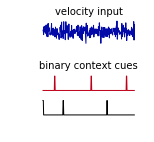

In [5]:
''' Figure 1E: inputs '''
f, gs = fig1_plots.plot_e(inputs["inp_vel"],\
                          inputs["inp_remaps"])
plt.show()
f.savefig(f'{save_folder}inputs.png', dpi=600, bbox_inches='tight')

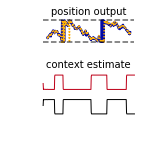

In [6]:
''' Figure 1F: outputs'''
f, gs = fig1_plots.plot_f(targets["pos_targets"],\
                          outputs["pos_outputs"],\
                          outputs["map_logits"])
plt.show()
f.savefig(f'{save_folder}outputs.png', dpi=600, bbox_inches='tight')

mean +/- standard error of the mean:
position loss: 0.0117 +/- 0.000378
context loss: 0.00258 +/- 4.03e-05


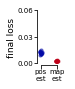

In [7]:
''' summary performance across models '''
f, ax = fig1_plots.plot_supp_1(data_folder, model_IDs)
plt.show()

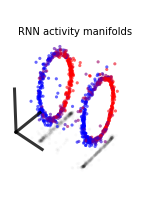

In [8]:
''' Figure 1H: aligned ring manifolds '''
f, ax = fig1_plots.plot_h(X, pos_targ)
plt.show()
f.savefig(f'{save_folder}manifolds.png', dpi=600, bbox_inches='tight')

mean alignment = 0.556
sem misalignment = 0.00886


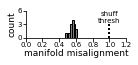

In [9]:
''' Figure 1I (or supp?): summary of ring alignment '''
f, ax = fig1_plots.plot_supp_2(data_folder, model_IDs)
f.savefig(f'{save_folder}alignment.png', dpi=600, bbox_inches='tight')
plt.show()


on average, 3 PCs explain 58.61% of the variance
on average, 12 PCs explain 90.45% of the variance


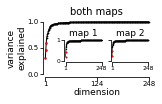

In [10]:
''' Figure 1J: summary of dimensionality '''
f, axes = fig1_plots.plot_j(data_folder, model_IDs,
                            top_num=3, top_num_1=2)
plt.show()
f.savefig(f'{save_folder}PCs_all.png', dpi=600, bbox_inches='tight')

In [12]:
''' generate a 'mouse-like' session
- non-negative velocity
- many steps
- rare remapping
'''
# select example model
ex_id = 0
model_ID = model_IDs[ex_id]

# set random seeds
NP_SEED = int(model_ID.split('_')[0])
TORCH_SEED = int(model_ID.split('_')[1])
random_state = np.random.RandomState(NP_SEED)
torch.manual_seed(TORCH_SEED)

# set params
model, task_params, rnn_params = model_utils.load_model_params(data_folder, model_ID)
n_batch = 50
session_params = {
    'num_maps': 2,
    'num_steps': 330,
    'remap_pulse_duration': 2,
    'remap_rate': 0.002,
    'velocity_drift_stddev': 0.1,
    'velocity_noise_stddev': 0.3}

# get sample neural activity, position targets, map targets, inputs
inp_init, inp_remaps, inp_vel, pos_targets, map_targets = \
        rnn.generate_batch_pos_vel(n_batch, random_state, **session_params)
pos_outputs, map_logits, hidden_states = model(inp_init, inp_vel, inp_remaps)

X = hidden_states.detach().numpy()

map_targ = map_targets.detach().numpy()

pos_targ = pos_targets.detach().numpy()
pos_targ = (pos_targ + np.pi) % (2 * np.pi) - np.pi

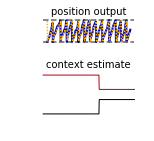

In [13]:
# check the output...
f, gs = fig1_plots.plot_f(pos_targets, pos_outputs, map_logits)
plt.show()

In [14]:
''' process the data '''
# trim unfinished traversals and flatten across the batch
X, pos_targ, map_targ = rnn.format_data(X.copy(), pos_targ.copy(), map_targ.copy())

In [15]:
# label each observation by traversal number
traversals_by_obs = rnn.traversal_num(pos_targ)
print(f'{np.max(traversals_by_obs)+1} total track traversals')

# find the predominant context for each traversal
map_idx = rnn.map_by_traversal(map_targ, traversals_by_obs)
n_remaps = np.sum(np.abs(np.diff(map_targ)))
print(f'{n_remaps} total remapping events')

# get the position-binned firing rates for each traversal
FR_by_traversal = rnn.fr_by_traversal(X, pos_targ, traversals_by_obs, n_pos_bins=50)

# calculate the trial-trial spatial similarity
sim = spk.spatial_similarity(FR_by_traversal.copy())

630 total track traversals
59.0 total remapping events


In [16]:
# choose example units
n_units = X.shape[-1]
n_ex_units = 5
possible_units = np.arange(n_units)
possible_units = possible_units[np.max(np.mean(FR_by_traversal, axis=0), axis=1) > 0.3]
ex_units = np.random.choice(possible_units, n_ex_units, replace=False)

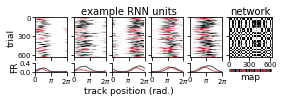

In [17]:
''' plot figure 1G: RNN single unit examples & network similarity '''
f, gs = fig1_plots.plot_g(FR_by_traversal, sim, map_idx, ex_units)
plt.show()
f.savefig(f'{save_folder}ex_tuning_similarity.png', dpi=600, bbox_inches='tight')

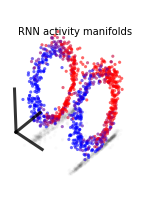

In [18]:
# just curious...
f, ax = fig1_plots.plot_h(X, pos_targ)
plt.show()

In [14]:
''' Figure 2E: alignment of the position and remapping dims to the inputs and outputs
TODO move this to a different fig (or supplemental fig?)
'''
# TODO reorganize these scripts
from procrustes import tuning_curve_1d, tuning_curve_2d
from dim_alignment import cosine_sim, proj_aB
import single_unit_analysis as analysis

# 1) Define the remapping dimension:
# Average activity in each context (hidden_size,)
X0_bar = np.mean(X0, axis=0)
X1_bar = np.mean(X1, axis=0)

# Find the remapping dimension
remap_dim = X0_bar - X1_bar

In [15]:
# 2) Define the position subspace:
# position-binned firing rates (n_pos_bins, hidden_size)
X0_tc = tuning_curve_1d(X0, pos0, n_bins=250)
X1_tc = tuning_curve_1d(X1, pos1, n_bins=250)

# mean-center, normalize, combine
m1 = X0_tc - np.mean(X0_tc, axis=0, keepdims=True)
m2 = X1_tc - np.mean(X1_tc, axis=0, keepdims=True)
m1_norm = np.linalg.norm(m1)
m2_norm = np.linalg.norm(m2)
m1 /= m1_norm
m2 /= m2_norm
X_all = np.concatenate((m1, m2), axis=0)

# PCA to get the position subspace (hidden_size, num_pcs) (p1, p2, p3)
num_pcs = 2
pca = PCA(n_components=num_pcs).fit(X_all)
pos_subspace = pca.components_.T

In [16]:
# 3) Get the input and output weights from the model
# inputs
ctxt_inp_w = model.linear_ih.weight[:, :-1]
pos_inp_w = model.linear_ih.weight[:, -1]
ctxt_inp_w = ctxt_inp_w.detach().numpy() # (hidden_size, n_maps)
pos_inp_w = pos_inp_w.detach().numpy() # (hidden_size, n_pos_dim)

# outputs
ctxt_out_w = model.readout_layer_map.weight
ctxt_out_w = ctxt_out_w.detach().numpy().T # (hidden_size, n_maps)
pos_out_w = model.readout_layer_pos.weight
pos_out_w = pos_out_w.detach().numpy().T # (hidden_size, n_pos_dim * 2)

In [17]:
# 4) Determine the relationship between the remapping dim/pos subspace and the inputs/outputs
# remap dim vs. the position inputs/outputs
pos_in_vs_remap = cosine_sim(remap_dim, pos_inp_w)
print(f'proj position inputs onto remap dim = {pos_in_vs_remap:.3}')
pos_out_vs_remap = cosine_sim(remap_dim, pos_out_w)
print(f'proj position outputs onto remap dim = {pos_out_vs_remap[0]:.3}, {pos_out_vs_remap[1]:.3}')

# remap dim vs. the context inputs/outputs
ctxt_in_vs_remap = cosine_sim(remap_dim, ctxt_inp_w)
print(f'\nproj context inputs onto remap dim = {ctxt_in_vs_remap[0]:.3}, {ctxt_in_vs_remap[1]:.3}')
ctxt_out_vs_remap = cosine_sim(remap_dim, ctxt_out_w)
print(f'proj context outputs onto remap dim = {ctxt_out_vs_remap[0]:.3}, {ctxt_out_vs_remap[1]:.3}')

# position subspace vs. the position inputs/outputs
pos_in_vs_pos = proj_aB(pos_inp_w, pos_subspace)
print(f'\nproj position inputs onto position subspace = {pos_in_vs_pos:.3}')
pos_out_vs_pos = proj_aB(pos_out_w, pos_subspace)
print(f'proj position outputs onto position subspace = {pos_out_vs_pos[0]:.3}, {pos_out_vs_pos[1]:.3}')

# position subspace vs. the context inputs/outputs
ctxt_in_vs_pos = proj_aB(ctxt_inp_w, pos_subspace)
print(f'\nproj context inputs onto position subspace = {ctxt_in_vs_pos[0]:.3}, {ctxt_in_vs_pos[1]:.3}')
ctxt_out_vs_pos = proj_aB(ctxt_out_w, pos_subspace)
print(f'proj context outputs onto position subspace = {ctxt_out_vs_pos[0]:.3}, {ctxt_out_vs_pos[1]:.3}')

proj position inputs onto remap dim = -0.0187
proj position outputs onto remap dim = -0.00298, -0.000556

proj context inputs onto remap dim = 0.462, -0.506
proj context outputs onto remap dim = 0.953, -0.95

proj position inputs onto position subspace = 0.0125
proj position outputs onto position subspace = 0.695, 0.682

proj context inputs onto position subspace = 0.0253, 0.0116
proj context outputs onto position subspace = 0.0112, 0.0166


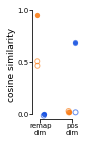

In [18]:
f, gs = fig_plots.plot_fig2e(ctxt_in_vs_remap, ctxt_in_vs_pos, \
                    ctxt_out_vs_remap, ctxt_out_vs_pos, \
                    pos_in_vs_remap, pos_in_vs_pos, \
                    pos_out_vs_remap, pos_out_vs_pos
                    )
plt.show()
f.savefig(f'{save_folder}align_orthog.png', dpi=600, bbox_inches='tight')

In [19]:
''' Figure 2F: fixed points on ring manifolds '''
# load the fixed points
fixed_pts_np = np.load(f"{base}/saved_models/{model_ID}/states_fixed_pt.npy")
fixed_pts = torch.from_numpy(fixed_pts_np)

# calculate the velocity at each fixed/slow point
num_batch = fixed_pts.shape[0]
num_maps = task_params["num_maps"]
inp_vel = torch.zeros(num_batch, 1)
inp_remaps = torch.zeros(num_batch, num_maps)

X1 = fixed_pts
X2 = model.one_step(fixed_pts, inp_vel, inp_remaps)
X1 = X1.detach().numpy()
X2 = X2.detach().numpy()

vels = np.asarray([])
for x1, x2 in zip(X1, X2): 
    vel = np.sum((x1 - x2)**2)
    vels = np.append(vels, vel)

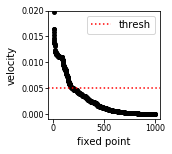

In [20]:
# filter out points where the velocity is too great
thresh = 0.005
sort_idx = np.argsort(vels)
f, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.scatter(np.arange(vels.shape[0]),
           vels[sort_idx[::-1]], 
           c='k', s=15,
           zorder=0)
xlims = ax.get_xlim()
ax.hlines(thresh, xlims[0], xlims[1],
          linestyles='dotted', colors='r',
          zorder=1, label='thresh'
         )

ax.set_xlim(xlims)
ax.set_ylim(-0.001, 0.02)
ax.set_ylabel('velocity')
ax.set_xlabel('fixed point')
ax.tick_params(which='major', labelsize=8, pad=1)
ax.legend()

plt.show()

In [21]:
print(f'filtered out {np.sum(vels > thresh)} slow points with velocity > {thresh}')
fixed_pts = fixed_pts[vels < thresh]
fixed_pts_np = fixed_pts_np[vels < thresh]

filtered out 190 slow points with velocity > 0.005


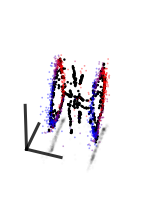

In [23]:
f, ax = fig_plots.plot_fig2f(X, fixed_pts, pos_targ)

ax.set_title('')

plt.show()
f.savefig(f'{save_folder}fixed_pts.png', dpi=600, bbox_inches='tight')